In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as pl
import wradlib
from osgeo import osr
import datetime as dt

from osgeo import gdal
from scipy.spatial import cKDTree

% matplotlib inline 


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
%%time

# Import radolan grid src
radolan_xy = wradlib.georef.get_radolan_grid(900,900)
radolan_xy = radolan_xy.reshape(-1, radolan_xy.shape[-1])
zd = wradlib.zonalstats.DataSource(radolan_xy, name='src')
#print(zd._name)
#gr_src = wradlib.zonalstats.gdal_create_dataset('Memory', 'out', gdal_type=gdal.OF_VECTOR)
#s_in, tmp_lyr = wradlib.io.open_vector('radolan_grid/src.shp', driver='ESRI Shapefile')

#gr_src_lyr = ogr_src.CopyLayer(tmp_lyr, zd._name)
#d._srs = ogr_src_lyr.GetSpatialRef()
#d._ds = ogr_src
#zd_poly_radolan = wradlib.zonalstats.ZonalDataPoint('radolan_grid')

CPU times: user 16.8 s, sys: 446 ms, total: 17.2 s
Wall time: 16.8 s



##  Data Input
----------------------------------
### Read an organize the data
--------------------------------



In [3]:
# new cutted gpm data
gpm_file = '/automount/ags/velibor/gpmdata/ipol_test/2A-CS-radolan.GPM.DPR.V7-20170308.20141007-S023418-E023728.003445.V05A.HDF5'
#gpm_file = '/automount/ags/velibor/gpmdata/ipol_test/2A-CS-radolan.GPM.DPR.V7-20170308.20140510-S220856-E221212.001124.V05A.HDF5'

# define the RADOLAN RY data
radolan_ry_file = '/automount/ags/velibor/gpmdata/ipol_test/raa01-ry_10000-1410070235-dwd---bin'
#radolan_ry_file = '/automount/ags/velibor/gpmdata/ipol_test/raa01-ry_10000-1405102210-dwd---bin'

## Interpolation Methode

In [4]:
def ipoli_radi(gr_grid, gr_data,sr_grid,radius):
    """

    Parameters
    ----------
    gr_grid ::: grid of the Ground Radar
    gr_data ::: data of the Ground Radar
    sr_grid ::: grid oft the Spaceborn Radar
    radius  ::: radius of the dpr foot prints


    Returns
    -------
    gs_grid ::: Interpolated Groundradar Data on Spaceborne Grid

    """
    import datetime as dt
    gr_ipoli_data = np.zeros((sr_grid.shape[0]))

    for i in range(sr_grid.shape[0]):

        # set x_0 and y_0
        x0, y0 = sr_grid[i,0], sr_grid[i,1] 

        # calc radius for all other points
        rr = np.sqrt((gr_grid[:,0] - x0)**2 + (gr_grid[:,1] - y0)**2)

        # check if footptint 
        if gr_data[rr < radius].size!=0:
            # if not empty calc mean
            #ToDo: wichtung fehlt!
            gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])

 
        else:
            # if empty set NAN
            gr_ipoli_data[i] = np.nan


    return gr_ipoli_data

## Remove all GPM scans not oncluded in radolan scan area
----------------------

In [5]:
def dpr_swath_contour(sr_grid):
    """
    Function for dpr swath grid contour
    ## sr_grid[:, 0] # - komplette linke Spalte
    ## sr_grid[-1,1:-1] # - obere Kante (ohne linke und rechte Ecke)
    ## sr_grid[:, -1][::-1] # - komplette rechte Spalte (rückwarts)
    ## sr_grid[0,0:-1] # - unter Kante (ohne rechte Ecke)
    
    """
    
    trg = np.r_[sr_grid[:, 0], sr_grid[-1, 1:-1], sr_grid[:, -1][::-1], sr_grid[0, 0:-1][::-1]]
    
    return trg


In [6]:
def idx_sr_in_gr_area(_bingrid, _gpm_xy):
    """
    Funktion:
    ---------
    Search for SR Footprint (Index) that are located in the GR scan area 
    
    Input: 
    ------
    _bingrid ::: Binary-grid of the GR scan area
        
    _gpm_xy ::: GPM footptint coordinates
    
    Output:
    -------
    
    _gpm_xy_outer_idx ::: index of all footprints not included in radolan scan area
    _gpm_xy_inner_idx ::: idex of all footprints included in radolan area but
                           not scanned by ground radars 
    
    """
    _gpm_xy = _gpm_xy.copy()
    # Bestimmen von Eckpunkten bei RADOLAN RY GRID!
    # HARDCODED: but ok for regula RADOLAN Produkts
    xmin, xmax = -523.4621669218559, 375.5378330781441
    ymin, ymax = -4658.644724265572, -3759.644724265572
    
    # Radolangitter um 1 gridpoit zu allen seiten erweitern
    _xex, _yex = np.arange(xmin-1, xmax+2, 1), np.arange(ymin-1, ymax+2, 1)
    _xxx, _yyy = np.meshgrid(_xex,_yex)
    
    # Bin grid bestimmen
    _bingrid = _bingrid.copy()
    _bingrid[_bingrid >= 0]=1
    _bingrid[_bingrid < 0]=0
    
    # Gittererweiterungen zusammenstellen
    ## rn_tb ::: bin gird top and bottom
    ## rn_lr ::: bin gird left and right
    rn_tb = np.zeros(900)
    rn_lr = np.zeros(902)
    
    # Griderweiterungen einsetzen
    # erst oben und unten
    rn1 = np.c_[rn_tb, _bingrid, rn_tb]
    # dann rechts
    rn2 = np.vstack((rn1, rn_lr))
    # dann rechts
    rn3 = np.vstack((rn_lr,rn2))
    
    from skimage import measure
    # Contouren des Bin-grids erstellen
    contours = measure.find_contours(rn3, 0, positive_orientation='high',
                                     fully_connected='high' )
    print(len(contours), ' detected Polygons')
    #print("---------------------")
    #for j in range(len(contours)):
    #    print(len(contours[j]))
    #print("---------------------")

    # bestiimung der Listen für Polygon Points
    _xx = []
    _yy = []

    # suche nach dem größten Polygon... dieser sollte der RADOLAN UMRISS sein
    for i in range(len(contours)):
        # Polygone mit 3 oder weniger points ergeben keine nutzbare Fläche
        if len(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)]) <= 3:
            print('not relevant polygon removed')
        else:   
            # PolygonPoints bestimmen (RADOLAN RAND POINTS)
            _xx.append(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            _yy.append(_yyy[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            
    # sortiern nach der länge, das letzt element ist das größte und sollte somit der Radolarand sein
    _xx.sort(key=len)
    _yy.sort(key=len)

    # Outter polygon erstellen
    _xy = np.vstack((_xx[-1].ravel(), _yy[-1].ravel())).transpose()    
    
    # Suche nach den GPM footprints im Scanngebiet von RADOLAN mit ZONALSTATS
    zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy])
    _gpm_xy_outer_idx = zdpoly.get_source_index(0)
    
    # Array for inner Polygons
    _gpm_xy_inner_idx = np.array([])
    
    # Entferne Inner Polygons
    # Auch nur wenn es weitere Polygone gibt 
    if len(_xx)>1:

        for inner_poly_index in range(len(_xx)-1):

            print ('Polygon size: ', len(_xx[inner_poly_index].ravel()))

            _xy_inner = np.vstack((_xx[inner_poly_index].ravel(),
                                  _yy[inner_poly_index].ravel())).transpose()

            _zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy_inner])

            _inner_idx = _zdpoly.get_source_index(0)

            _gpm_xy_inner_idx = np.append(_gpm_xy_inner_idx, _inner_idx)


            if _gpm_xy_inner_idx.size==0:
                print ('inner polygons do not match with SR grid')

            else:
                print('match idx with inner polygon: ', _gpm_xy_inner_idx.shape)
                    

        
    return _gpm_xy_outer_idx, _gpm_xy_inner_idx 
        

In [7]:
def dpr_antenna_weighting(r):
    """
    Funktion: eplained in 
    Watters, D., A. Battaglia, K. Mroz, and F. Tridon, 0: 
    Validation of the GPM Version-5 Surface Rainfall 
    Products over Great Britain and Ireland. 
    J. Hydrometeor., 0, https://doi.org/10.1175/JHM-D-18-0051.1
    """
    
    omega = np.exp(-(r/2.5)**2. * np.log10(4.))
    
    return omega

In [8]:
t1 = dt.datetime.now()

## Read GPM Data
---------------------------------------


In [9]:
%%time
# read gpm file with importatnt parameters
gpmdpr = h5py.File(gpm_file, 'r')

# Scan swath
sc = 'NS'

# GPM navigation and time
gpm_lat = np.array(gpmdpr[sc]['Latitude'])
gpm_lon = np.array(gpmdpr[sc]['Longitude'])

# Precipitation data in RADOLAN region
dpr_pns = np.array(gpmdpr[sc]['SLV']['precipRateESurface'])
dpr_pns[dpr_pns ==-9999.9]= np.nan

CPU times: user 10.9 ms, sys: 111 µs, total: 11 ms
Wall time: 245 ms


## GPM coordinates projection
----------------------------------------------

In [10]:
%%time

proj_stereo = wradlib.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

gpm_x, gpm_y = wradlib.georef.reproject(gpm_lon, gpm_lat,
                                        projection_target=proj_stereo,
                                        projection_source=proj_wgs)

CPU times: user 66.9 ms, sys: 0 ns, total: 66.9 ms
Wall time: 67.8 ms


## Read RADOLAN Data
-----------------

In [11]:
%%time

# read radolan ry file
rwdata, rwattrs = wradlib.io.read_radolan_composite(radolan_ry_file)

radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
x = radolan_grid_xy[:,:,0]
y = radolan_grid_xy[:,:,1]
rwdata = np.ma.masked_equal(rwdata, -9999) *8#/ 2 - 32.5

# copy data for binary grid
bingrid = rwdata.copy()

CPU times: user 46.1 ms, sys: 12.1 ms, total: 58.2 ms
Wall time: 72.2 ms


## Remove all GPM footprint that are not in scan area of radolan
-------------------

In [12]:
%%time

# GPM Koordinaten revelen 
gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()

outer_idx, inner_idx = idx_sr_in_gr_area(bingrid, gpm_xy)

#gpm_xy = gpm_xy[outer_idx]

# Hässliche Variante
# entferne alle Indizes aus dem inneren Polygon
idx_r = ~np.isin(outer_idx, inner_idx)

# entferne alle Indizes auserhalb des äußeren Polygons
gpm_xy = gpm_xy[outer_idx[idx_r]]
gpm_pns = dpr_pns.ravel()[outer_idx[idx_r]]

(1, ' detected Polygons')
CPU times: user 630 ms, sys: 58.2 ms, total: 688 ms
Wall time: 637 ms


In [13]:
inner_idx, outer_idx

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


(array([], dtype=float64),
 array([ 2499,  2548,  2597, ..., 11389, 11425, 11437]))

## Remove all RADOLAN Points not included in GPM DPR swath
-------------------------------

In [14]:
%%time
# Contour from original DPR Overpass
dpr_contour_x = dpr_swath_contour(gpm_x)
dpr_contour_y = dpr_swath_contour(gpm_y)
print(dpr_contour_x.shape)

(641,)
CPU times: user 199 µs, sys: 0 ns, total: 199 µs
Wall time: 189 µs


In [15]:
"""%%time
# Create an binary grid 
xn = x.copy() 
yn = y.copy() 
rwdatan = rwdata.copy() 
rwdatan[rwdatan >= 0]=1
rwdatan[rwdatan < 0]=0

# Use only data in binary grid
xn = xn[rwdatan==1]
yn = yn[rwdatan==1]
rwdatan1 = rwdata[rwdatan==1]"""

'%%time\n# Create an binary grid \nxn = x.copy() \nyn = y.copy() \nrwdatan = rwdata.copy() \nrwdatan[rwdatan >= 0]=1\nrwdatan[rwdatan < 0]=0\n\n# Use only data in binary grid\nxn = xn[rwdatan==1]\nyn = yn[rwdatan==1]\nrwdatan1 = rwdata[rwdatan==1]'

In [16]:
%%time
#pl.scatter(xn[::30], yn[::30], alpha=0.3)
#pl.scatter(dpr_contour_x, dpr_contour_y, color='black', edgecolors='none')


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [17]:
%%time
# Create xy array for coordinates in binary grid
#xy = np.vstack((xn.ravel(), yn.ravel())).transpose()

# create dpr polygon of dpr xy contours 
dpr_xy_poly = np.vstack((dpr_contour_x.ravel(), dpr_contour_y.ravel())).transpose()

CPU times: user 63 µs, sys: 3 µs, total: 66 µs
Wall time: 99.9 µs


In [18]:
#%%time
#xy_radolan = np.vstack((x.ravel(), y.ravel())).transpose()
#zd_poly_radolan = wradlib.zonalstats.ZonalDataPoint(xy_radolan, [dpr_xy_poly], buf=2.5)
#zd_poly_radolan.dump_vector('radolan_grid')

In [19]:
%%time
#load regular radolan grid and overlie with dpr contours
zd_poly_radolan = wradlib.zonalstats.ZonalDataPoint(zd, [dpr_xy_poly], buf=2.5)
# get radolan index in dpr swath
ry_idx = zd_poly_radolan.get_source_index(0)

# get radolan index in dpr swath AND in binary grid
rwtest = ~np.ma.masked_less(rwdata, 0).mask

#rint(rwtest.shape, rwtest1.shape)

radolan_idx = np.flatnonzero(rwtest.ravel())

#rint(radolan_idx.shape)
ry_idx2 = np.intersect1d(ry_idx, radolan_idx, assume_unique=True)

CPU times: user 9.23 s, sys: 78 ms, total: 9.31 s
Wall time: 9.24 s


In [20]:
xy_radolan = np.vstack((x.ravel(), y.ravel())).transpose()
#pl.scatter(xy_radolan[...,0][::30], xy_radolan[...,1][::30], alpha=0.3)
#pl.scatter(dpr_contour_x, dpr_contour_y, color='black', edgecolors='none')

In [21]:

#pl.scatter(xy_radolan[...,0][ry_idx][::30], xy_radolan[...,1][ry_idx][::30], alpha=0.3)
#pl.scatter(dpr_contour_x, dpr_contour_y, color='black', edgecolors='none')
#pl.scatter(xy_radolan[...,0][radolan_idx][::30], xy_radolan[...,1][radolan_idx][::30], alpha=0.3, color='red')


In [22]:
#pl.scatter(xy_radolan[...,0][ry_idx2], xy_radolan[...,1][ry_idx2], s=2, alpha=0.3)

In [23]:
#%%time
#zd_poly_radolan.dump_vector('radolan_grid')

#zdpoly_4ry = wradlib.zonalstats.ZonalDataPoly(xy,[dpr_xy_poly], buf=2.5)

#ry_idx_old = zdpoly_4ry.get_source_index(0)

In [24]:
%%time
rwdata_cut = rwdata.ravel()[ry_idx2]
x_cut = xy_radolan[...,0].ravel()[ry_idx2].copy()
y_cut = xy_radolan[...,1].ravel()[ry_idx2].copy()

CPU times: user 5.28 ms, sys: 39 µs, total: 5.32 ms
Wall time: 4.22 ms


In [25]:
#x_cut.shape, y_cut.shape, rwdata_cut.shape

In [26]:
%%time
#pl.scatter(x_cut, y_cut, c=rwdata_cut,s=2, edgecolors='none', vmin=0, vmax=10)
#pl.colorbar()


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


## Interpolation of radolan to dpr 
-------------------------

In [27]:
%%time

## INTERLOLATION
## --------------

xy_cut = np.vstack((x_cut.ravel(), y_cut.ravel())).transpose()

#Dpr footprint radius 
dpr_footprint = 2.6 #radius in km


CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 1.19 ms


In [28]:
%%time

# cKDTree radolan
tree = cKDTree(xy_cut)

# cKDTree gpm dpr
tree_gpm = cKDTree(gpm_xy)

CPU times: user 566 ms, sys: 3.9 ms, total: 570 ms
Wall time: 568 ms


In [29]:
%%time
#res = tree_gpm.query_ball_tree(tree,dpr_footprint)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [30]:
%%time
dists, ix = tree.query(gpm_xy, k=25) # Hardcoded k but maximal possible ry pixel in dpr footprint
ix2 = tree.query_ball_point(gpm_xy, dpr_footprint)

CPU times: user 128 ms, sys: 3.93 ms, total: 132 ms
Wall time: 132 ms


In [31]:
%%time
ry_pns_w = []

for i in range(ix.shape[0]):
    #i is all points in one dpr footprint
    #distancen für jeden i 
    index = np.isin(ix[i,:],ix2[i] )
    res1 = np.nansum( dpr_antenna_weighting(dists[i,:][index]) * rwdata_cut.ravel()[ix[i,:][index]])
    res2 = np.nansum(dpr_antenna_weighting(dists[i,:][index]))
    
    ry_pns_w.append(res1/res2)
    
    #np.array(ix2[455])
    
ry_pns_w = np.array(ry_pns_w)    



CPU times: user 3.36 s, sys: 2.85 ms, total: 3.36 s
Wall time: 3.36 s


In [32]:
print('-----------------')
print(dt.datetime.now() - t1)
print('-----------------')


-----------------
0:00:14.586629
-----------------


## Some Comparison of 2d Data
--------------------------------------------

CPU times: user 668 ms, sys: 411 ms, total: 1.08 s
Wall time: 526 ms


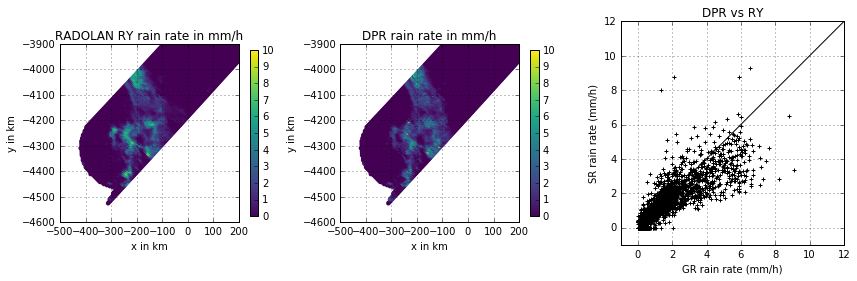

In [33]:
%%time

fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(gpm_xy[..., 0], gpm_xy[...,1], c=ry_pns_w, cmap=pl.cm.viridis, vmin=0, vmax=10, edgecolor="None")
pl.title("RADOLAN RY rain rate in mm/h")
pl.colorbar(shrink=0.3)
pl.xlabel("x in km")
pl.ylabel("y in km")
pl.xlim(-500, 200)
pl.ylim(-4600, -3900)
pl.grid()

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(gpm_xy[..., 0], gpm_xy[...,1], c=gpm_pns, cmap=pl.cm.viridis, vmin=0, vmax=10, edgecolor="None")
pl.title("DPR rain rate in mm/h")
pl.colorbar(shrink=0.3)
pl.xlabel("x in km")
pl.ylabel("y in km")
pl.xlim(-500, 200)
pl.ylim(-4600, -3900)
pl.grid()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(ry_pns_w, gpm_pns, marker="+", c="black")
pl.plot([0,60],[0,60], linestyle="solid", color="black")
pl.xlim(-1,12)
pl.ylim(-1,12)
pl.xlabel("GR rain rate (mm/h)")
pl.ylabel("SR rain rate (mm/h)")
pl.title("DPR vs RY")
pl.grid()

pl.tight_layout()

## Correlations
-------------------------------

In [34]:
print('Corr mit Nullen: ', np.corrcoef(ry_pns_w,gpm_pns)[0][1])

('Corr mit Nullen: ', 0.912615567488543)


In [35]:
ry_pns0, gpm_pns0 = ry_pns_w.copy(), gpm_pns.copy()

ry_pns0[ry_pns0 <= 0.] = np.nan
gpm_pns0[gpm_pns0 <= 0.] = np.nan

nullmaske = ~np.isnan(ry_pns0) & ~np.isnan(gpm_pns0)
print('Corr ohne Nullen bei beiden: ', np.corrcoef(ry_pns0[nullmaske],gpm_pns0[nullmaske])[0][1])


('Corr ohne Nullen bei beiden: ', 0.8102992066251786)


In [36]:
ry_pns05, gpm_pns05 = ry_pns_w.copy(), gpm_pns.copy()

ry_pns05[(ry_pns05 <= 0.) & (gpm_pns05 <= 0.)] = np.nan
gpm_pns05[(ry_pns05 <= 0.) & (gpm_pns05 <= 0.)] = np.nan

nullmaske5 = ~np.isnan(ry_pns05) & ~np.isnan(gpm_pns05)

print('Corr Nur wenn Null bei beiden: ', np.corrcoef(ry_pns05[nullmaske5],gpm_pns05[nullmaske5])[0][1])


('Corr Nur wenn Null bei beiden: ', 0.8728615089540828)


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


## Explanation of antenna gain weighting
-----------------------------------------------------------

$$\omega_i = exp[-(r_i/2.5)^2 ln(4)]$$

$i$ : corresponds to each 1 km RADOLAN pixel in DPR Footprint

$r_i$ : distance in kilometers between Radolan Pixel and DPR center point

##### The Weighted GR estimates in DPR footprint:

$$\bar{GR} = \frac{ \sum\nolimits_{i=1}^N \omega_i GR_i }{ \sum\nolimits_{i=1}^N \omega_i} $$

> Funktion: eplained in 
>    Watters, D., A. Battaglia, K. Mroz, and F. Tridon, 0: 
>    Validation of the GPM Version-5 Surface Rainfall 
>    Products over Great Britain and Ireland. 
>    J. Hydrometeor., 0, https://doi.org/10.1175/JHM-D-18-0051.1

In [37]:
x = y = np.arange(-3,3,0.01)
xx, yy = np.meshgrid(x,y)
rr = np.sqrt(xx**2 +yy**2)

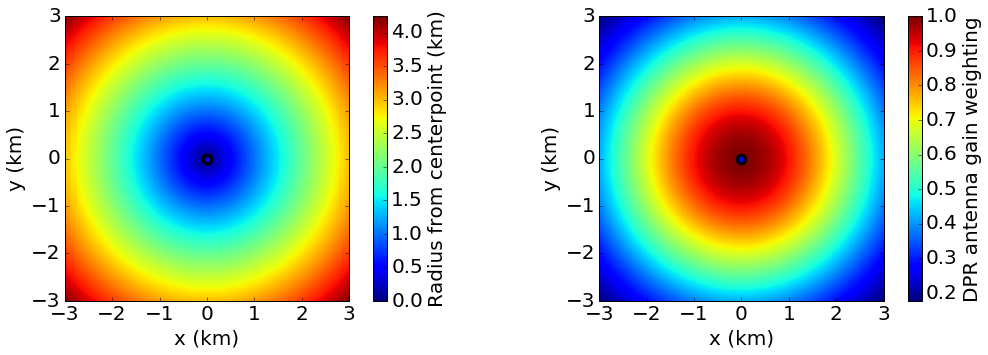

In [39]:
pl.figure(figsize=(15,5))
ff=20; cc=1
pl.subplot(1,2,1, aspect='equal')
pl.pcolormesh(xx,yy,rr)
cb = pl.colorbar(shrink=cc)
cb.set_label("Radius from centerpoint (km)", fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.scatter([0,0],[0,0], s=70, lw=3)
#pl.title('Radius from centerpoint (km)', fontsize=ff)
pl.xlabel('x (km)', fontsize=ff);pl.ylabel('y (km)', fontsize=ff)
pl.xlim(-3,3),pl.ylim(-3,3)
pl.xticks(fontsize=ff); pl.yticks(fontsize=ff)


pl.subplot(1,2,2, aspect='equal')
pl.pcolormesh(xx,yy,dpr_antenna_weighting(rr))
cb = pl.colorbar(shrink=cc)
cb.set_label("DPR antenna gain weighting", fontsize=20)
cb.ax.tick_params(labelsize=20)
pl.scatter([0,0],[0,0], s=70, lw=3)
pl.xlim(-3,3),pl.ylim(-3,3)
#pl.title('DPR Antenna gain weighting', fontsize=ff)
pl.xlabel('x (km)', fontsize=ff);pl.ylabel('y (km)', fontsize=ff)
pl.xticks(fontsize=ff); pl.yticks(fontsize=ff)

pl.tight_layout()